# See PDF notes on body forces before working through this notebook!
# Sympy computation of the hand notes on the bar hanging under its own weight!
# The correct way - Consistent Nodal Loads $f_x A L \int_{-1}^{1} [N1,N2,N3]^\textrm{T} \frac{1}{2} d\xi$
# which results in $$f_x A L \begin{bmatrix} \frac{1}{6}\\ \frac{1}{6}\\ \frac{2}{3}\end{bmatrix}$$
# That is a 1/6 of the total load $f_x A L$ is applied at the end nodes and 2/3 in the middle node - this is only true for a constant body force over the element and constant geometry (area) over the element.

A: 0.0100000000000000
dxdxi 0.500000000000000
B [2.0*xi - 1.0, 2.0*xi + 1.0, -4.0*xi]
B here is a vector when considering the shape (3,) 
If we want to levarage the multiplication symbol * to do linear Algebra multiplication we can cast B into a column vector 3x1 and then take the tranpose to get a row vector
sympy.Matrix support for shape=(1,3) has unfortunately not been incorporated!
Hence to convert a vector into a (1,3) matrix we need to:
Convert vector into sympy.Matrix has shape (3, 1) i.e. 3 rows and 1 column
Transpose recast it as a 1x3 matrix with shape (1, 3)
Hence we convert vector into a 3x1 matrix, when we convert into a 1x3 matrix
BT*E*B whichs is a 3x1 vector times a 1x3 vector Matrix([[(2.0*xi - 1.0)*(420000000000.0*xi - 210000000000.0), (2.0*xi + 1.0)*(420000000000.0*xi - 210000000000.0), -4.0*xi*(420000000000.0*xi - 210000000000.0)], [(2.0*xi - 1.0)*(420000000000.0*xi + 210000000000.0), (2.0*xi + 1.0)*(420000000000.0*xi + 210000000000.0), -4.0*xi*(420000000000.0*xi + 

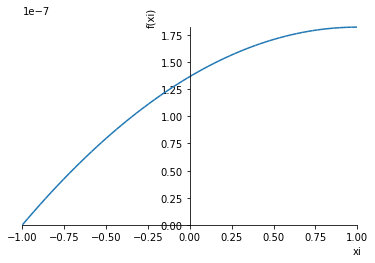

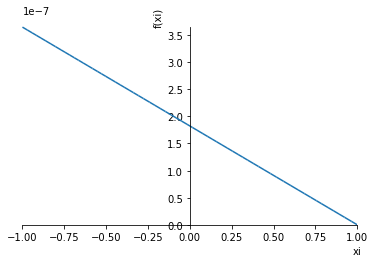

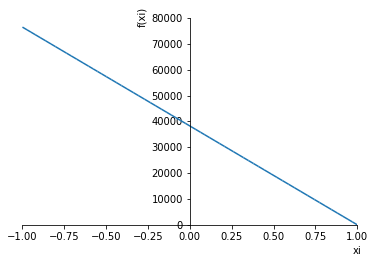

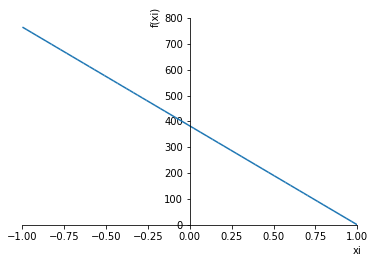

Critically interpret the result!
Area is constant!
Is the displacement as expected? Yip, zero at the top. Shape indicates largest strain (largest slope) at where it is clamped and the slope decreaes towards 0 to the bottom of the bar
Stress largest at where it is clamped, since all the weight of the bar is below it at that point. At the bottom no stress since nothing is applying load at the bottom i.e. zero traction at that surface.
The values make sense total F = rho*g*A*L = 765.18 - maximum stress at top should therefore be F/A = 76 518 N/mˆ2 - which it is!
The internal force also makes sense total F = rho*g*A*L = 765.18 N - maximum internal force in fact matches exactly not only approximately!
The internal force at bottom is also 0 as expected, since nothing is hanging at the bottom of the bar


In [37]:
import numpy as np
import sympy as sp
xi = sp.symbols('xi')

# Define the shape functions
N1 = -1/2*xi*(1-xi)
N2 = 1/2*xi*(1+xi)
N3 = (1-xi)*(1+xi)

# Isoparametric formulation - relate x and xi
x1 = 0;x2 = 1;x3 = 0.5
x = N1*x1 + N2*x2 + N3*x3

# Define the area in terms of x, which in turn is related to xi - here A(xi) since x(xi).
A = 0.01 + xi*0
print('A: {}'.format(A.simplify()))

E = 210E9
L = 1.0
g = 9.81
rho = 7800

# Compute non-zero surface traction
fx = g*rho

# Setup a list of the shape functions N1, N2 and N3
N = [N1,N2,N3]

# Stiffness matrix
dxdxi = sp.derive_by_array(x,xi); print('dxdxi {}'.format(dxdxi))
dxidx = 1/dxdxi

B = dxidx*sp.derive_by_array(N,xi); print('B {}'.format(B))
print('B here is a vector when considering the shape {} '.format(B.shape))

print('If we want to levarage the multiplication symbol * to do linear Algebra multiplication we can cast B into a column vector 3x1 and then take the tranpose to get a row vector')
print('sympy.Matrix support for shape=(1,3) has unfortunately not been incorporated!')
print('Hence to convert a vector into a (1,3) matrix we need to:' )
print('Convert vector into sympy.Matrix has shape {} i.e. 3 rows and 1 column'.format(sp.Matrix(B).shape))
print('Transpose recast it as a 1x3 matrix with shape {}'.format(sp.Matrix(B).transpose().shape))
print('Hence we convert vector into a 3x1 matrix, when we convert into a 1x3 matrix')
Bmat = sp.Matrix(B).transpose() # sp.Matrix converts a 3 vector (3) into a column vector (3x1) by default!s
BTEB = Bmat.transpose()*E*Bmat; print('BT*E*B whichs is a 3x1 vector times a 1x3 vector {}'.format(BTEB))

integrandStiffnessMatrix = BTEB*A*dxdxi
# 2-point Gauss Quadrature Integration
StiffnessMatrix = 1.0*integrandStiffnessMatrix.subs({xi:-1/3**0.5}) + 1.0*integrandStiffnessMatrix.subs({xi:1/3**0.5})

# Traction vector that results in force is given by
Fintegrand = g*rho*A*sp.Matrix(N)*dxdxi
F = 1.0*Fintegrand.subs({xi:-1/3**0.5}) + 1.0*Fintegrand.subs({xi:1/3**0.5}); print('Body Force Vector {}'.format(F))

#The first row is multiplied by W1=0, hence only row 2&3 remains, we move the first column to the traction side 
StiffnessMatrixReduced = StiffnessMatrix[1:,1:]
#Matrix has a built-in method solve, we need to only specify the Right-Hand-Side of the Linear System to Solve
solution = StiffnessMatrixReduced.solve(F[1:,0]-StiffnessMatrix[1:,0]*0); print('Solution for q2 and q3 is {}'.format(solution))

# Here we override 
q1 = 0 # prescribed displacement
q2 = solution[0,0] #solution from 2x2 Matrix system which is a 2x1 vector
q3 = solution[1,0] #solution from 2x2 Matrix system which is a 2x1 vector
q = sp.Matrix([q1,q2,q3])

# Plotting the result - here we levarage built-in dot operator for the sympy.Matrix object
u = sp.Matrix(N).dot(q) # Matrix with shape functions dot with solution vector
sp.plot(u,(xi,-1,1))

strain = Bmat.dot(q) # B matrix dot with solution vector
sp.plot(strain,(xi,-1,1))

stress = E*strain
sp.plot(stress,(xi,-1,1))

internalforce = stress*A
sp.plot(internalforce,(xi,-1,1))

print('Critically interpret the result!')
print('Area is constant!')
print('Is the displacement as expected? Yip, zero at the top. Shape indicates largest strain (largest slope) at where it is clamped and the slope decreaes towards 0 to the bottom of the bar')
print('Stress largest at where it is clamped, since all the weight of the bar is below it at that point. At the bottom no stress since nothing is applying load at the bottom i.e. zero traction at that surface.')
print('The values make sense total F = rho*g*A*L = 765.18 - maximum stress at top should therefore be F/A = 76 518 N/mˆ2 - which it is!')
print('The internal force also makes sense total F = rho*g*A*L = 765.18 N - maximum internal force in fact matches exactly not only approximately!')
print('The internal force at bottom is also 0 as expected, since nothing is hanging at the bottom of the bar')



# Splitting the body force just equally over the three nodes
# $$f_x A L \begin{bmatrix} \frac{1}{3}\\ \frac{1}{3}\\ \frac{1}{3}\end{bmatrix}$$
# which is often what one may expect intuitively. This is WRONG, look at the results to see why!

Body Force Vector Matrix([[255.060000000000], [255.060000000000], [255.060000000000]])
Solution for q2 and q3 is Matrix([[1.82185714285714e-7], [1.13866071428571e-7]])


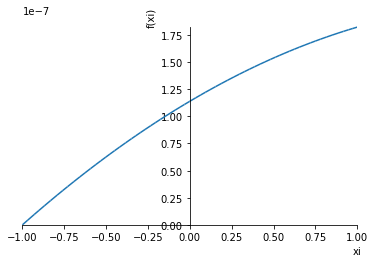

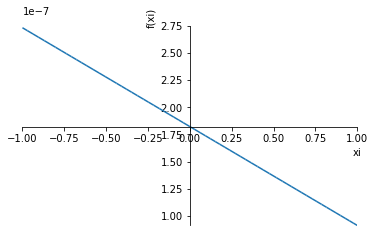

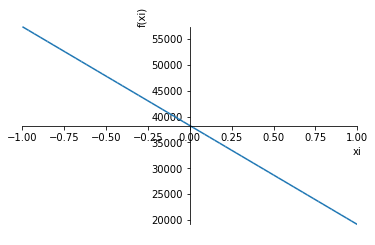

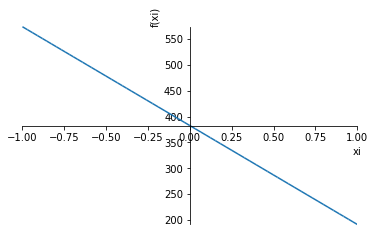

Critically interpret the result!
Area is constant!
Is the displacement as expected? Yip, zero at the top. Shape indicates largest strain (largest slope) at where it is clamped and the slope decreaes towards 0 to the bottom of the bar
Stress largest at where it is clamped, since all the weight of the bar is below it at that point. At the bottom no stress since nothing is applying load at the bottom i.e. zero traction at that surface.
The values make sense total F = rho*g*A*L = 765.18 - maximum stress at top should therefore be F/A = 76 518 N/mˆ2 - which it is NOT as it is just over 55 000 N/m^2 - 30% less than what it should be!
The internal force valus also DOES NOT make sense since total F = rho*g*A*L = 765.18 but maximum internal force at top of plot is ONLY around 550 N!
The internal force at bottom should be 0 but it is just over 200N


In [36]:
F = rho*g*A*sp.Matrix([1/3,1/3,1/3]); print('Body Force Vector {}'.format(F))

#The first row is multiplied by W1=0, hence only row 2&3 remains, we move the first column to the traction side 
StiffnessMatrixReduced = StiffnessMatrix[1:,1:]
#Matrix has a built-in method solve, we need to only specify the Right-Hand-Side of the Linear System to Solve
solution = StiffnessMatrixReduced.solve(F[1:,0]-StiffnessMatrix[1:,0]*0); print('Solution for q2 and q3 is {}'.format(solution))

# Here we override 
q1 = 0 # prescribed displacement
q2 = solution[0,0] #solution from 2x2 Matrix system which is a 2x1 vector
q3 = solution[1,0] #solution from 2x2 Matrix system which is a 2x1 vector
q = sp.Matrix([q1,q2,q3])

# Plotting the result - here we levarage built-in dot operator for the sympy.Matrix object
u = sp.Matrix(N).dot(q) # Matrix with shape functions dot with solution vector
sp.plot(u,(xi,-1,1))

strain = Bmat.dot(q) # B matrix dot with solution vector
sp.plot(strain,(xi,-1,1))

stress = E*strain
sp.plot(stress,(xi,-1,1))

internalforce = stress*A
sp.plot(internalforce,(xi,-1,1))

print('Critically interpret the result!')
print('Area is constant!')
print('Is the displacement as expected? Yip, zero at the top. Shape indicates largest strain (largest slope) at where it is clamped and the slope decreaes towards 0 to the bottom of the bar')
print('Stress largest at where it is clamped, since all the weight of the bar is below it at that point. At the bottom no stress since nothing is applying load at the bottom i.e. zero traction at that surface.')
print('The values make sense total F = rho*g*A*L = 765.18 - maximum stress at top should therefore be F/A = 76 518 N/mˆ2 - which it is NOT as it is just over 55 000 N/m^2 - 30% less than what it should be!')
print('The internal force valus also DOES NOT make sense since total F = rho*g*A*L = 765.18 but maximum internal force at top of plot is ONLY around 550 N!')
print('The internal force at bottom should be 0 but it is around 200N')
